In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
NTURN = [1024,1024*2]

nCore_y = 4
nCore_z = 4

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.28
NL_L = 1.8
dTune = 0.01

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu
lattice[1].pipe_radius = 0.02*np.sqrt(2)

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

### 1.2. generate particles

In [6]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
npt = len(pTest)
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 7668


In [7]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

In [8]:
lattice[0].turns = NTURN[0]

TBT = impact.getElem('TBT')
TBT.file_id = NTURN[0]
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.file_id = NTURN[0]
OUTPUT.turn = NTURN[0]
OUTPUT.format_id = 2
lattice.append(OUTPUT)

# FMA

### Run Forward 

In [9]:
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [10]:
for nturn in NTURN[:-1]:
    lattice[0].turns = nturn
    TBT.file_id = nturn*2
    OUTPUT.turn = nturn
    OUTPUT.file_id = nturn*2
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)

### Load Data

In [11]:
iTBT = {}
TBT = {}
X = {}
Y = {}
Npt = {}

for nturn in NTURN:
    print(nturn)
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])

1024
2048


In [12]:
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn

0 1024 1024 7262 7262
0 1024 2048 7199 7199
1024 2048 2048 7199 7199


### Apply NAFF

In [13]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [14]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}

for nturn in NTURN[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        signal = X[nturn][:int(nturn/2),i]# -np.mean(X[nturn][:int(nturn/2),i])
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = X[nturn][int(nturn/2):,i]# -np.mean(X[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        
        signal = Y[nturn][:int(nturn/2),i]# -np.mean(Y[nturn][:int(nturn/2),i])
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = Y[nturn][int(nturn/2):,i]# -np.mean(Y[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
        
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

### Plot

In [19]:
n = NTURN[-1]
p_nuy0 = np.logical_or(tuneYbefore[n]<0.01, tuneYbefore[n]>0.99)

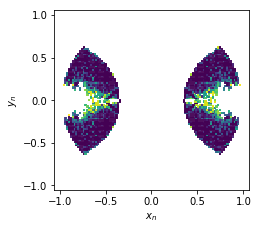

In [20]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
plt.figure(figsize=[3.7,3.3])
plt.scatter(np.real(X[n][0,p_nuy0]),np.real(Y[n][0,p_nuy0]),c=Adiff[n][p_nuy0],s=1.6,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.tight_layout()
plt.savefig('DA.nu_y=0.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.png',dpi=180)